<a href="https://colab.research.google.com/github/chaiminwoo0223/Deep-Learning/blob/main/26%20-%20Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Import

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
%matplotlib inline

# Hyperparameter

In [2]:
batch_size = 256
lr = 0.0002
num_epoch = 5

# Data
## 1.Data Download

In [3]:
mnist_train = dset.MNIST(",/", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST(",/", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

## 2.Set DataLoader

In [4]:
train_loader = DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers=2, drop_last=True)
test_loader = DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers=2, drop_last=True)

# Model
## 1.Encoder

In [5]:
class Encoder(nn.Module):
    def __init__(self):
        super(Encoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding=1),    # batch x 16 x 28 x 28
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.Conv2d(16, 32, 3, padding=1),   # batch x 32 x 28 x 28
            nn.ReLU(),
            nn.BatchNorm2d(32),
            nn.Conv2d(32, 64, 3, padding=1),   # batch x 64 x 28 x 28
            nn.ReLU(),
            nn.BatchNorm2d(64),
            nn.MaxPool2d(2, 2)                 # batch x 64 x 14 x 14
        )
        self.layer2 = nn.Sequential(
            nn.Conv2d(64, 128, 3, padding=1),  # batch x 128 x 14 x 14
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.MaxPool2d(2, 2),                # batch x 128 x 7 x 7
            nn.Conv2d(128, 256, 3, padding=1), # batch x 256 x 7 x 7
            nn.ReLU()
        )

    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size, -1) 
        return out

## 2.Decoder

In [6]:
class Decoder(nn.Module):
    def __init__(self):
        super(Decoder, self).__init__()
        self.layer1 = nn.Sequential(
            nn.ConvTranspose2d(256, 128, 3, 2, 1, 1), # batch x 128 x 14 x 14
            nn.ReLU(),
            nn.BatchNorm2d(128),
            nn.ConvTranspose2d(128, 64, 3, 1, 1),     # batch x 64 x 14 x 14
            nn.ReLU(),
            nn.BatchNorm2d(64)
        )
        self.layer2 = nn.Sequential(
            nn.ConvTranspose2d(64, 16, 3, 1, 1),      # batch x 16 x 14 x 14
            nn.ReLU(),
            nn.BatchNorm2d(16),
            nn.ConvTranspose2d(16, 4, 3, 1, 1),       # batch x 4 x 14 x 14
            nn.ReLU(),
            nn.BatchNorm2d(4),
            nn.ConvTranspose2d(4, 1, 3, 2, 1, 1),     # batch x 1 x 14 x 14
            nn.ReLU()
        )

    def forward(self, x):
        out = x.view(batch_size, 256, 7, 7)            
        out = self.layer1(out)
        out = self.layer2(out)
        return out

## 3.Model On GPU

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 4.Loss_Func & Optimizer

In [8]:
encoder = Encoder().to(device)
decoder = Decoder().to(device)
parameters = list(encoder.parameters()) + list(decoder.parameters())
loss_func = nn.MSELoss()
optimizer = optim.Adam(parameters, lr=lr)

# Train

In [9]:
for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader):
        optimizer.zero_grad()
        image = image.to(device)
        
        output = encoder(image)
        output = decoder(output)
        loss = loss_func(output, image)
        loss.backward()
        optimizer.step()
        
    if j % 10 == 0:
        print(loss)

torch.Size([256, 28, 28])


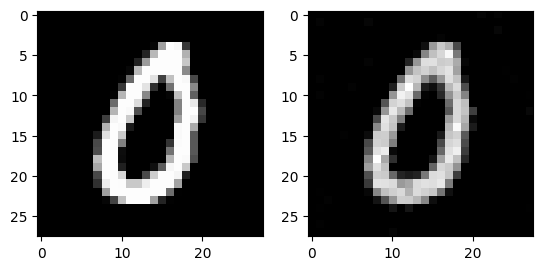

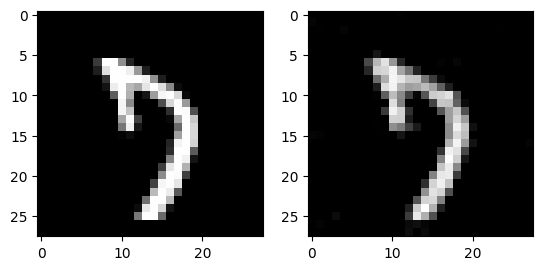

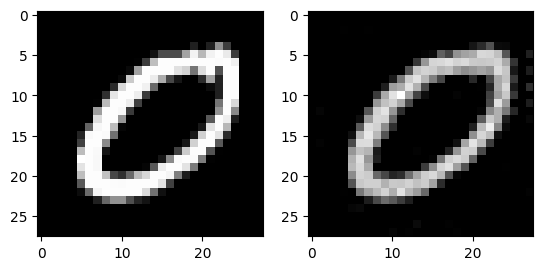

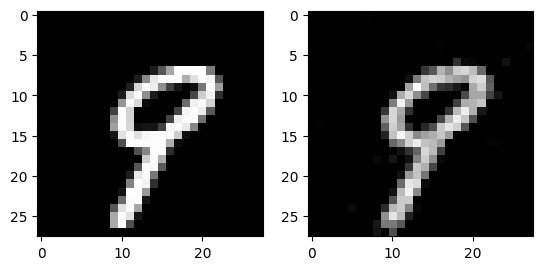

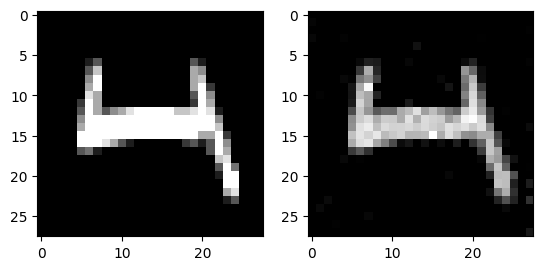

In [10]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1, 2, 1)
    plt.imshow(torch.squeeze(image[i]).cpu().numpy(), cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(out_img[i].numpy(), cmap='gray')
    plt.show()

# Test

In [11]:
with torch.no_grad():
    for j, [image, label] in enumerate(test_loader):
        image = image.to(device)
        output = encoder(image)
        output = decoder(output)
        
        if j % 10 == 0:
            print(loss)

tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0034, device='cuda:0', grad_fn=<MseLossBackward0>)


torch.Size([256, 28, 28])


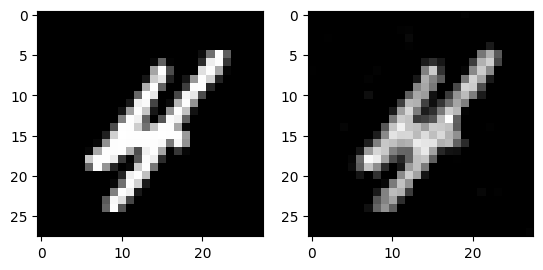

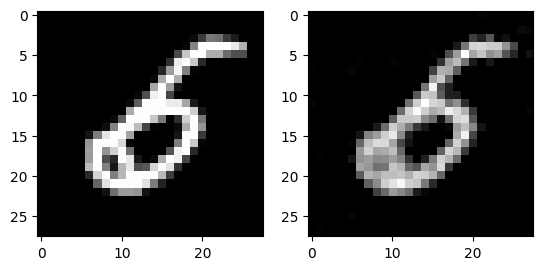

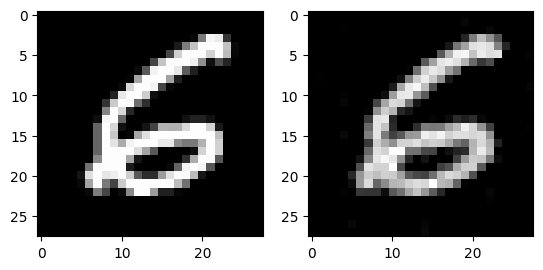

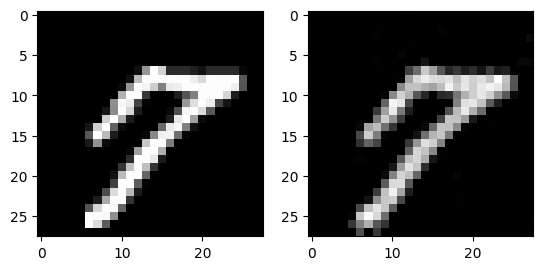

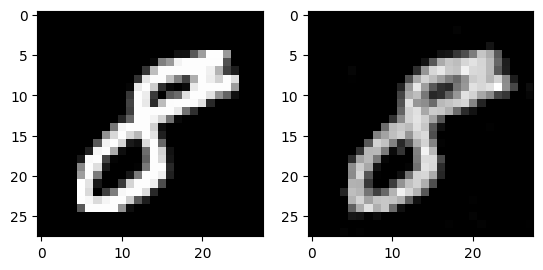

In [12]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1, 2, 1)
    plt.imshow(torch.squeeze(image[i]).cpu().numpy(), cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(out_img[i].numpy(), cmap='gray')
    plt.show()

# Noise

In [13]:
for i in range(num_epoch):
    for j, [image, label] in enumerate(train_loader):
        optimizer.zero_grad()
        image = image.to(device)
        noise = init.normal_(torch.FloatTensor(batch_size, 1, 28 ,28), 0, 0.1)
        noise = noise.to(device)
        noise_image = image + noise
        
        output = encoder(noise_image)
        output = decoder(output)
        loss = loss_func(output, noise_image)
        loss.backward()
        optimizer.step()
        
    if j % 10 == 0:
        print(loss)

torch.Size([256, 28, 28])


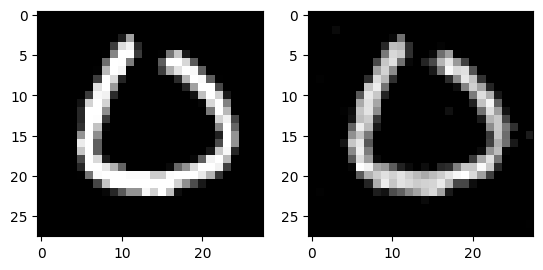

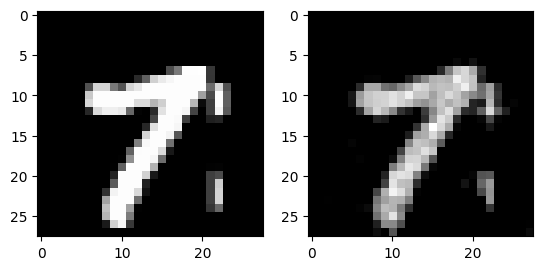

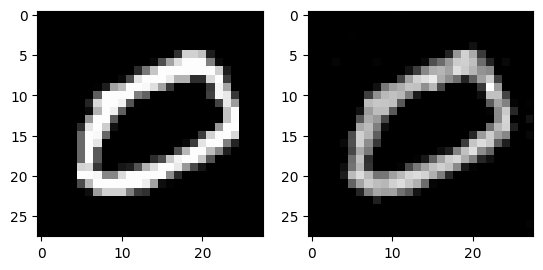

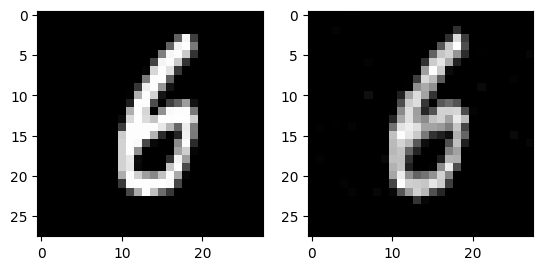

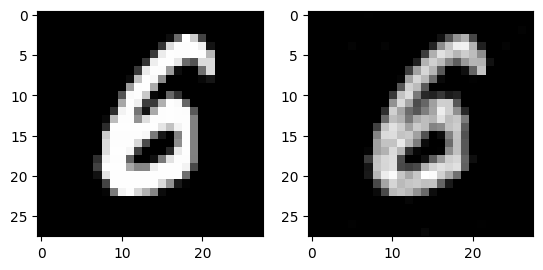

In [14]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1, 2, 1)
    plt.imshow(torch.squeeze(image[i]).cpu().numpy(), cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(out_img[i].numpy(), cmap='gray')
    plt.show()

In [15]:
with torch.no_grad():
    for j, [image, label] in enumerate(test_loader):
        image = image.to(device)
        noise = init.normal_(torch.FloatTensor(batch_size, 1, 28 ,28), 0, 0.1)
        noise = noise.to(device)
        noise_image = image + noise
        output = encoder(noise_image)
        output = decoder(output)
        
        if j % 10 == 0:
            print(loss)

tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)
tensor(0.0108, device='cuda:0', grad_fn=<MseLossBackward0>)


torch.Size([256, 28, 28])


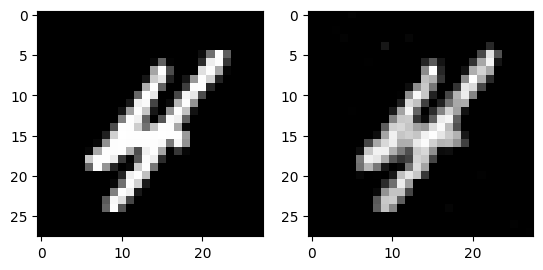

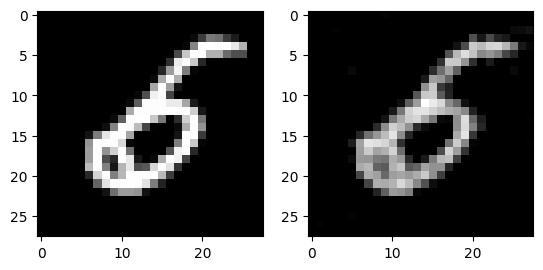

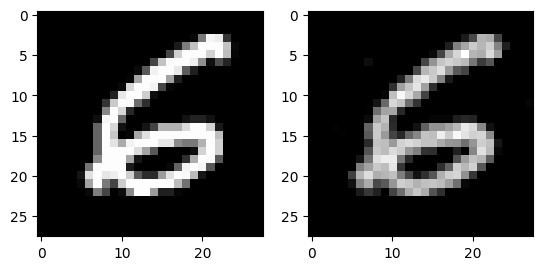

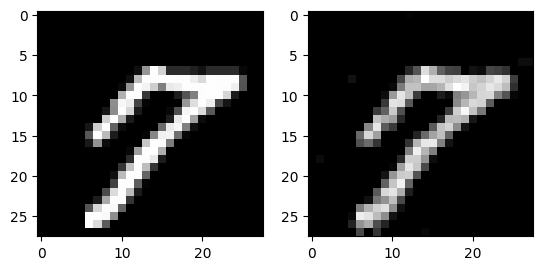

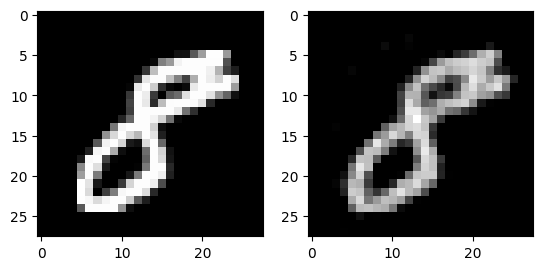

In [16]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(5):
    plt.subplot(1, 2, 1)
    plt.imshow(torch.squeeze(image[i]).cpu().numpy(), cmap='gray')
    plt.subplot(1, 2, 2)
    plt.imshow(out_img[i].numpy(), cmap='gray')
    plt.show()